## In this notebook, we will analyze NY Green Taxi Data for the month of February 2016, and build a Machine Learning Model to forecast the number of trips

##### Q1. Download the data, load it into python. Report the number of rows and columns that you've loaded.

In [78]:
# Importing relevant libraries 
import pandas as pd
import numpy as np
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [79]:
# Reading the data into a pandas dataframe
taxi_df = pd.read_csv('green_tripdata_2016-02.csv') 

# Lets take a peek at the data
taxi_df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,10.5,0.5,0.5,0.00,0.0,NaN,0.3,11.80,2,1.0
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,13.0,0.5,0.5,0.00,0.0,NaN,0.3,14.30,2,1.0
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,17.5,0.5,0.5,3.76,0.0,NaN,0.3,22.56,1,1.0
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1.0
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [80]:
# Lets have a look at the column names in this data
taxi_df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

In [81]:
# Now to Q1, lets print the number of rows and columns in the dataframe

print("The data consists of {} rows and {} columns" .format(taxi_df.shape[0], taxi_df.shape[1]))

The data consists of 1510722 rows and 21 columns


##### Q2. Visualize trip distance by time of day in any way you see fit, any observations?

In [82]:
# In orders to get a good visual representation of how trips are distributed over the day, lets extract some key 
# info from the date columns. Before that, we convert the columns from type string to type datetime

taxi_df['Pickup_DateTime'] = taxi_df.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
taxi_df['Dropoff_DateTime'] = taxi_df.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
taxi_df['Pickup_Hour'] = taxi_df['Pickup_DateTime'].apply(lambda x: x.hour)
taxi_df['DayOfMonth'] = taxi_df['Pickup_DateTime'].apply(lambda x: x.strftime("%d"))
taxi_df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,Pickup_DateTime,Dropoff_DateTime,Pickup_Hour,DayOfMonth
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,0.0,NaN,0.3,11.80,2,1.0,2016-02-01 00:00:01,2016-02-01 00:10:06,0,01
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,0.0,NaN,0.3,14.30,2,1.0,2016-02-01 00:01:33,2016-02-01 00:20:13,0,01
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,0.0,NaN,0.3,22.56,1,1.0,2016-02-01 00:03:46,2016-02-01 00:21:04,0,01
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,0.0,NaN,0.3,9.30,2,1.0,2016-02-01 00:00:05,2016-02-01 00:06:48,0,01
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,0.0,NaN,0.3,6.30,2,1.0,2016-02-01 00:06:20,2016-02-01 00:08:47,0,01


In [83]:
# Lets extract Pickup Hour and Trip Distance to plot. We will plot Pickup Hour against the 
# Mean Distance travelled for that hour

distbyhour_df = taxi_df[['Pickup_Hour', 'Trip_distance']]
distbyhour_df = distbyhour_df.groupby(['Pickup_Hour'], as_index=False).mean()

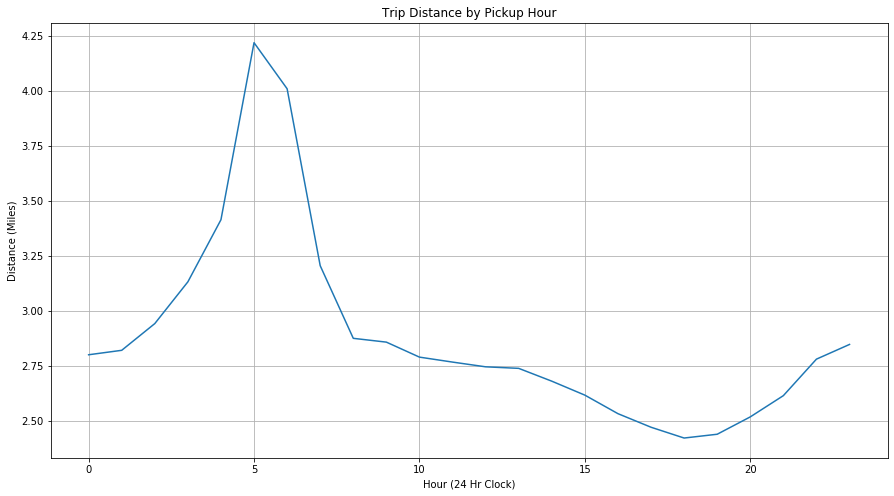

In [84]:
# Plotting

plt.figure(figsize=(15,8))
plot = sns.lineplot(data=distbyhour_df, x='Pickup_Hour', y='Trip_distance')
plot.set(xlabel='Hour (24 Hr Clock)', ylabel='Distance (Miles)')
plt.grid()
plt.title('Trip Distance by Pickup Hour')

plt.show(plot)

##### As we can see, pickups around 5am have a considerable spike in terms of distance of trip. This may be because a lot of people travel to airports at that time for work

##### Q3. What are the most popular pickup locations on weekends vs weekdays?

In [85]:
# To answer this question, we need a new column to tell us if a particular date falls on a weekend or weekday

taxi_df['DayofWeek'] = taxi_df['Pickup_DateTime'].apply(lambda x: x.isoweekday())

In [86]:
taxi_df['WeekdayOrWeekend'] = np.where(taxi_df['DayofWeek'].isin([1,2,3,4,5]), 'Weekday', 'Weekend')

In [87]:
taxi_df['Pickup_latitude'] = taxi_df['Pickup_latitude'].astype(str)
taxi_df['Pickup_longitude'] = taxi_df['Pickup_longitude'].astype(str)
taxi_df['lat_long'] = taxi_df['Pickup_latitude'] + ', ' + taxi_df['Pickup_longitude']

In [88]:
# Calculating the count of lat long occurances on weekdays and weekends
popular_pickups = taxi_df[['WeekdayOrWeekend', 'lat_long']].groupby(['WeekdayOrWeekend', 'lat_long'],
                                                 as_index=False).size().reset_index(name='count')
popular_pickups = popular_pickups[popular_pickups['lat_long']!='0.0, 0.0']
popular_pickups_wday = popular_pickups[popular_pickups['WeekdayOrWeekend']=='Weekday'].sort_values('count', 
                                                                                            ascending=False)
popular_pickups_wend = popular_pickups[popular_pickups['WeekdayOrWeekend']=='Weekend'].sort_values('count', 
                                                                                            ascending=False)

In [89]:
# A look at the highest lat long counts on weekdays
popular_pickups_wday.head()

,WeekdayOrWeekend,lat_long,count
352585,Weekday,"40.721351623535156, -73.84429168701173",45
532628,Weekday,"40.76477432250977, -73.9369583129883",40
352378,Weekday,"40.721336364746094, -73.84427642822266",38
352586,Weekday,"40.721351623535156, -73.84429931640625",37
352377,Weekday,"40.721336364746094, -73.84426879882812",35


In [90]:
# A look at the highest lat long counts on weekends
popular_pickups_wend.head()

,WeekdayOrWeekend,lat_long,count
1113030,Weekend,"40.721351623535156, -73.84429931640625",17
1112788,Weekend,"40.72132873535156, -73.84427642822266",16
1113189,Weekend,"40.72136688232422, -73.84429931640625",15
1113026,Weekend,"40.721351623535156, -73.84426879882812",14
1113029,Weekend,"40.721351623535156, -73.84429168701173",14


In [91]:
# Lets get the adress details for the most popular pickup locations on both, weekdays and weekend

locator = Nominatim(user_agent="myGeocoder")
geocode = locator.reverse
wday_suburbs = list(popular_pickups_wday['lat_long'][0:1].apply(geocode))
wend_suburbs = list(popular_pickups_wend['lat_long'][0:1].apply(geocode))

##### Most popular pickup location for weekdays is:

In [92]:
wday_suburbs[0].raw['address']

{'house_number': '107-50',
 'road': 'Queens Boulevard',
 'suburb': 'Queens',
 'city': 'New York',
 'state': 'New York',
 'postcode': '11375',
 'country': 'United States of America',
 'country_code': 'us'}

##### Most popular pickup location for the weekend is:

In [93]:
wend_suburbs[0].raw['address']

{'house_number': '107-50',
 'road': 'Queens Boulevard',
 'suburb': 'Queens',
 'city': 'New York',
 'state': 'New York',
 'postcode': '11375',
 'country': 'United States of America',
 'country_code': 'us'}

##### A lat-long corresponding to Queens Boulevard in the suburb of Queens seems to be the most popular location for pickups on weekdays as well as weekends

##### Q4. Build a model to forecast the number of trips by hour for the next 12 hours after Feb 12th 10:00 am.

In [94]:
# First, lets get our data ready for modeling. Lets split our time series data into train and test

ts_df = taxi_df[['DayOfMonth', 'Pickup_Hour']]
ts_df['DayOfMonth'] = ts_df['DayOfMonth'].astype(int)
ts_train_df_1 = ts_df[ts_df['DayOfMonth']<12].reset_index(drop=True)
ts_train_df_2 = ts_df[(ts_df['DayOfMonth']==12) & 
                                (ts_df['Pickup_Hour']<11)].reset_index(drop=True)
ts_train_df = pd.concat([ts_train_df_1, ts_train_df_2])
ts_train_df['DayOfMonth'] = ts_train_df['DayOfMonth'].astype(str)
ts_train_df['Pickup_Hour'] = ts_train_df['Pickup_Hour'].astype(str)
ts_train_df['DayHour'] = ts_train_df['DayOfMonth'] + ts_train_df['Pickup_Hour']
ts_train_df = ts_train_df[['DayHour']].groupby('DayHour', as_index=False).size().reset_index(name='count')

ts_test_df = ts_df[(ts_df['DayOfMonth']==12) & (ts_df['Pickup_Hour']>=11) &
                  (ts_df['Pickup_Hour']<=22)].reset_index(drop=True)
ts_test_df['DayOfMonth'] = ts_test_df['DayOfMonth'].astype(str)
ts_test_df['Pickup_Hour'] = ts_test_df['Pickup_Hour'].astype(str)
ts_test_df['DayHour'] = ts_test_df['DayOfMonth'] + ts_test_df['Pickup_Hour']
ts_test_df = ts_test_df[['DayHour']].groupby('DayHour', as_index=False).size().reset_index(name='count')

/Users/denverdias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [95]:
# Lets have a look at our training data and visualize it to see if we can find any insights

ts_train_df.head()

,DayHour,count
0,10,1290
1,100,1153
2,101,706
3,1010,2004
4,1011,1891


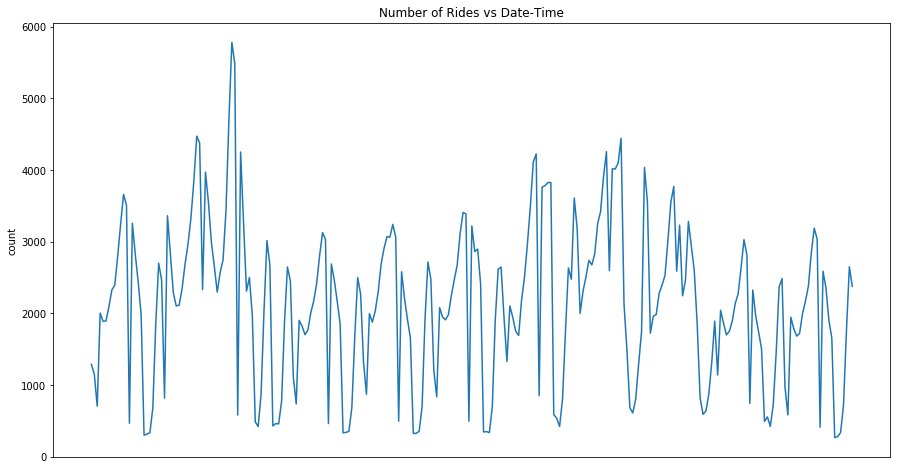

In [96]:
# Plotting 
plt.figure(figsize=(15,8))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Number of Rides vs Date-Time')
plot = sns.lineplot(data=ts_train_df, x='DayHour', y='count')
plt.show(plot)

##### Before we proceed with building any time-series model, we always check for data stationarity which tells us if our data is time dependent or not. One popular statistical test we can use is the Augmented Dickey-Fuller test. Our Null hypothesis here is that the data is stationary.

In [97]:
X = ts_train_df[['count']]
res = adfuller(X)
print('ADF Statistic: {}' .format(res[0]))
print('Critical Values:')
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.412541244637471
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


##### As we can see, for alpha value of 0.05 and 0.10, our Critical Value is more that our Test Statistic,  which means that we fail to reject the Null Hypothesis that our data is stationary. We can now go ahead with building our time series models.

##### ARIMA Models are very popular in demand forecasting, especaill in data with no trend and a high correlation with lags of itself. Lets go ahead and fit our data to an ARIMA model and use it to make predictions. Before we build an ARIMA Model, we always plot ACF (Auto Correlation Function) and PACF (Partial Auto Correlation Function) in order to understand if our model is an AR or MA Model and identify our p, d, q parameters.

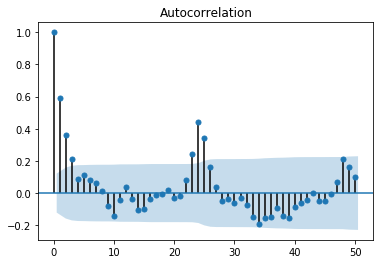

In [98]:
# Plotting ACF

acf_plot = plot_acf(X, lags=50)
plt.show(acf_plot)

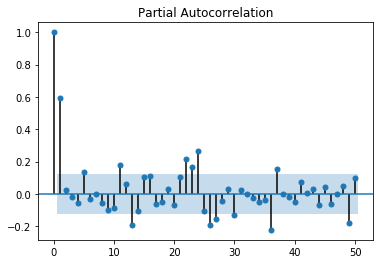

In [99]:
# Plotting PACF

pacf_plot = plot_pacf(X, lags=50)
plt.show(pacf_plot)

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                  260
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2158.724
Method:                       css-mle   S.D. of innovations            976.280
Date:                Mon, 26 Oct 2020   AIC                           4323.448
Time:                        16:59:23   BIC                           4334.130
Sample:                             1   HQIC                          4327.743
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4509     49.583      0.090      0.928     -92.729     101.631
ar.L1.D.count    -0.2220      0.060     -3.679      0.000      -0.340      -0.104
                                    Root

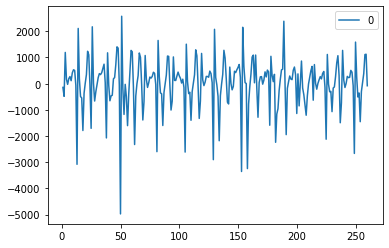

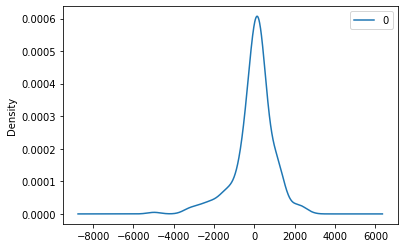

                 0
count   260.000000
mean     -0.088520
std     978.164795
min   -4973.365331
25%    -309.060558
50%     119.102676
75%     437.430950
max    2575.441820


In [100]:
# It is clear from the 2 plots that our data fits an AR Model with an order of 1. This is because 
# the PACF Function shows a sharp drop after 1 lag whereas the AR Function has a gradual decay.

# Fitting an AR MODEL of Order 1
model = ARIMA(X, order=(1,1,0))
fit = model.fit(disp=0)
print(fit.summary())

# Plotting resuiduals
res = pd.DataFrame(fit.resid)
res.plot()
plt.show()

# Plotting residual distribution
res.plot(kind='kde')
plt.show()

# Checking residual stats
print(res.describe())

##### Residual plot shows us that we have captured trend information well. 
##### Density plot shows that residuals are normally distributed around mean 0.

In [101]:
# Using the predict function to make predictions for the next 12 hours.
# First, lets look at our test data

y = ts_test_df[['count']]
y.head()

,count
0,2175
1,2024
2,2106
3,2716
4,3009


In [102]:
# Lets build an iterative model, where, every time we make a prediction for a test 
# observation k, we add that observation toour training set to predict test observation k+1 

historic_data = [i[0] for i in X.values]
pred = []
for i in range(len(y)):
    model = ARIMA(historic_data, order=(1,1,0))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast()
    y_pred = forecast[0]
    pred.append(y_pred)
    obs = y['count'][i]
    historic_data.append(obs)
    print('predicted={}, expected={}' .format(y_pred, obs))
error = mean_squared_error(y, pred)
print('MSE: {}' .format(error))

predicted=[2444.03794156], expected=2175
predicted=[2224.46463471], expected=2024
predicted=[2061.19643099], expected=2106
predicted=[2091.62149739], expected=2716
predicted=[2587.19216357], expected=3009
predicted=[2952.22310968], expected=3517
predicted=[3415.2672351], expected=4040
predicted=[3937.94656776], expected=4564
predicted=[4464.61575962], expected=4725
predicted=[4705.670682], expected=4432
predicted=[4510.17904862], expected=4048
predicted=[4143.92809968], expected=3870
MSE: 184574.47866415067


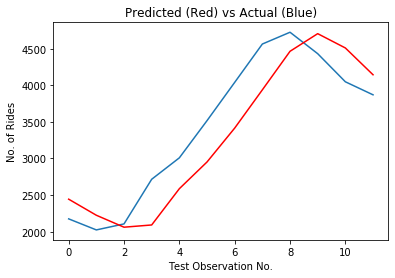

In [103]:
# Plotting our Predictions vs Actuals
plt.title('Predicted (Red) vs Actual (Blue)')
plt.xlabel('Test Observation No.')
plt.ylabel('No. of Rides')
plt.plot(y)
plt.plot(pred, color='red')
plt.show()

##### As we can see, our predictions work well at identifying change in demand but does tend to marginally under/over shoot with a few predictions. Overall, the model is a robust one (with RMSE 184,574) and helps us confidently forecast demand for Green Taxis within NY.

# -----------------------------------END-----------------------------------